# 🧭 Etapa 1: Preparación y Verificación Inicial del Dataset

En esta primera fase del proyecto final, nos enfocamos en la carga, inspección y verificación de la integridad de los datos. Para ello, realizamos los siguientes pasos:

1. **Montaje de Google Drive y extracción del dataset comprimido** desde la ruta especificada.
2. **Carga del archivo CSV** que contiene los metadatos de los Puntos de Interés Turístico (POIs).
3. **Creación de la variable objetivo `engagement`**, una etiqueta binaria calculada a partir de las métricas de interacción (Likes, Bookmarks, Visits, Dislikes), que clasifica los POIs en:
   - `1`: Engagement alto (por encima de la mediana del score)
   - `0`: Engagement bajo
4. **Verificación de disponibilidad de imágenes**, asegurándonos de que cada POI cuente con una imagen representativa (`main.jpg`) correctamente enlazada.
5. **Inspección de la distribución de clases**, importante para garantizar un balance adecuado entre las clases al entrenar el modelo.

Esta etapa asegura que el dataset esté correctamente estructurado y que todas las observaciones tengan tanto metadatos como imágenes asociadas, cumpliendo con los requisitos de integridad para el posterior análisis y modelado híbrido.


In [1]:
# 🎯 Proyecto Final - Predicción del Éxito de Atracciones Turísticas
# ========================
# 1. Configuración y carga inicial
# ========================

# 📦 Imports necesarios
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 🎲 Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# 🔗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 🗂️ Definir rutas (ya descomprimido en Drive)
base_path = "/content/drive/MyDrive/Proyecto/Proyecto"
csv_path = os.path.join(base_path, "poi_dataset.csv")
images_path = os.path.join(base_path, "data_main")

# 📄 Cargar CSV
df = pd.read_csv(csv_path)

# 🎯 Crear columna de engagement binario
df["engagement_score"] = df["Likes"] + df["Bookmarks"] + df["Visits"] - df["Dislikes"]
threshold = df["engagement_score"].median()
df["engagement"] = (df["engagement_score"] > threshold).astype(int)


# ✅ verificar si la imagen existe
def image_exists(poi_id):
    image_path = os.path.join(images_path, poi_id, "main.jpg")
    return os.path.exists(image_path)

# ✅ calculamos la columna de imágenes
df["has_image"] = df["id"].apply(image_exists)

# ✅ Mostramos de nuevo el conteo correcto
print("📄 Columnas del dataset:", df.columns.tolist())
print("\n📈 Distribución de clases (engagement):")
print(df["engagement"].value_counts())
print(f"\n🖼️ Total de POIs con imagen: {df['has_image'].sum()}")
print(f"❌ POIs sin imagen: {len(df) - df['has_image'].sum()}")




Mounted at /content/drive
📄 Columnas del dataset: ['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path', 'engagement_score', 'engagement', 'has_image']

📈 Distribución de clases (engagement):
engagement
0    785
1    784
Name: count, dtype: int64

🖼️ Total de POIs con imagen: 1569
❌ POIs sin imagen: 0


## 🔀 División del Dataset en Train, Validación y Test

Para entrenar y evaluar el modelo de manera robusta, se dividió el dataset original en tres subconjuntos:

- **70% para entrenamiento** (`train`): utilizado para ajustar los pesos del modelo.
- **15% para validación** (`val`): utilizado para monitorear el rendimiento durante el entrenamiento y ajustar hiperparámetros.
- **15% para test** (`test`): utilizado para evaluar la capacidad final del modelo en datos no vistos.

La división se realizó de forma **estratificada** según la variable `engagement`, para asegurar que la proporción de clases (alta y baja participación) se mantenga en cada conjunto.

Esta estrategia permite entrenar el modelo, validarlo durante el proceso y obtener una métrica final objetiva sin riesgo de sobreajuste.


In [2]:

# División 1: separamos 15% del total para test
df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    stratify=df["engagement"],
    random_state=42
)

# División 2: del 85% restante, separamos 17.65% para validación
df_train, df_val = train_test_split(
    df_temp,
    test_size=0.1765,  # ≈ 15 / 85
    stratify=df_temp["engagement"],
    random_state=42
)

# Verificación de proporciones
total = len(df)
print(f"📚 Train: {len(df_train)} muestras ({len(df_train)/total:.2%})")
print(f"📈 Val:   {len(df_val)} muestras ({len(df_val)/total:.2%})")
print(f"🧪 Test:  {len(df_test)} muestras ({len(df_test)/total:.2%})")


📚 Train: 1097 muestras (69.92%)
📈 Val:   236 muestras (15.04%)
🧪 Test:  236 muestras (15.04%)


## 🖼️ Transformaciones de Imagen

Antes de alimentar las imágenes al modelo, aplicamos las siguientes transformaciones:

1. **Redimensionar** todas las imágenes a `(128, 128)` para tener un tamaño uniforme.
2. **Convertir a Tensor** con `ToTensor()`, que normaliza los valores de píxel de `[0, 255]` a `[0.0, 1.0]`.
3. **Normalizar** con media `0.5` y desviación estándar `0.5` para cada canal, lo que transforma los valores al rango `[-1, 1]`. Esto mejora la estabilidad del entrenamiento.

Estas transformaciones se aplican automáticamente al cargar cada imagen dentro del dataset personalizado.
## 🧩 Dataset Personalizado con PyTorch

Creamos una clase `POIDataset` que hereda de `torch.utils.data.Dataset`. Esta clase permite:

- Cargar una imagen desde la ruta correspondiente a cada POI.
- Seleccionar las columnas numéricas del CSV como **atributos estructurados**.
- Escalar los atributos con `StandardScaler` (media 0, varianza 1).
- Devolver cada muestra como un par:
  - Entrada: `(imagen_tensor, atributos_tensor)`
  - Salida: `engagement` (0 o 1)

Esta clase organiza los datos de forma eficiente y compatible con el modelo de PyTorch.


In [3]:
from sklearn.preprocessing import StandardScaler
class POIDataset(Dataset):
    def __init__(self, dataframe, images_root, transform=None):
        self.df = dataframe
        self.images_root = images_root  # Ruta base de las carpetas de imágenes
        self.transform = transform

        # 🔹 Elegimos solo las columnas numéricas útiles como entrada estructurada
        # Tomamos solo columnas numéricas válidas (automático)
        self.struct_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()

        # Quitamos la columna de la etiqueta
        if "engagement" in self.struct_cols:
         self.struct_cols.remove("engagement")

        # 🔹 Escalamos todos los datos estructurados (normalización tipo Z)
        self.scaler = StandardScaler()
        self.structured_data = self.scaler.fit_transform(dataframe[self.struct_cols])

    def __len__(self):
        # Total de muestras
        return len(self.df)

    def __getitem__(self, idx):
        # 🔸 1. Accedemos a la fila del DataFrame
        row = self.df.iloc[idx]
        poi_id = row["id"]

        # 🔸 2. Cargamos la imagen: /<images_root>/<poi_id>/main.jpg
        img_path = os.path.join(self.images_root, poi_id, "main.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 🔸 3. Tomamos los datos estructurados escalados
        struct_tensor = torch.tensor(self.structured_data[idx], dtype=torch.float32)

        # 🔸 4. Tomamos la etiqueta
        label = torch.tensor(row["engagement"], dtype=torch.float32)

        # 🔸 5. Devolvemos imagen + datos estructurados como input, y la etiqueta como output
        return (image, struct_tensor), label


### 📦 Preparación de Datasets y DataLoaders

Una vez realizada la división en `train`, `val` y `test`, se crean instancias del dataset personalizado `POIDataset` para cada subconjunto.

Cada `POIDataset` se encarga de:
- Cargar las imágenes desde su ruta correspondiente.
- Aplicar transformaciones como redimensionado y normalización.
- Escalar los atributos estructurados con `StandardScaler`.
- Devolver cada muestra como una tupla: `(imagen, atributos), etiqueta`.

Posteriormente, se crean los `DataLoaders`, que permiten:
- Cargar los datos en lotes (`batch_size=16`).
- Barajar los datos en entrenamiento (`shuffle=True`).
- Entregar datos de forma eficiente durante el entrenamiento y la validación.

Estos `DataLoaders` serán los que alimenten al modelo en cada etapa.



In [4]:

# 🖼️ Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # imágenes normalizadas a [-1, 1]
])

# 🧩 Datasets personalizados (usa la clase POIDataset)
train_dataset = POIDataset(df_train, images_path, transform=transform)
val_dataset   = POIDataset(df_val,   images_path, transform=transform)
test_dataset  = POIDataset(df_test,  images_path, transform=transform)

# 🚚 DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)



## ✅ Validación de los DataLoaders y Visualización de Muestra

Antes de entrenar el modelo, se realiza una verificación del correcto funcionamiento de los `DataLoaders`. Para ello:

- Se extrae un batch del `train_loader` y se imprime la forma (`shape`) de:
  - Las imágenes: deben tener forma `[batch_size, 3, 128, 128]`.
  - Los datos estructurados: deben coincidir con el número de columnas numéricas utilizadas.
  - Las etiquetas: deben tener forma `[batch_size]`, representando la clase binaria de `engagement`.

Adicionalmente, se visualiza una imagen real del dataset con su etiqueta correspondiente.  
Para ello, se toma una muestra individual del `train_dataset`, se convierte el tensor normalizado de nuevo al rango `[0, 1]`, y se muestra usando `matplotlib`.

Esta comprobación asegura que las imágenes se están cargando y transformando correctamente, y que los datos están organizados en la estructura esperada para alimentar al modelo.


In [5]:
for (images, structs), labels in train_loader:
    print("🖼️ Imagenes:", images.shape)           # (batch_size, 3, 128, 128)
    print("📊 Datos estructurados:", structs.shape)  # (batch_size, num_features)
    print("🏷️ Etiquetas:", labels.shape)         # (batch_size,)
    break


🖼️ Imagenes: torch.Size([16, 3, 128, 128])
📊 Datos estructurados: torch.Size([16, 9])
🏷️ Etiquetas: torch.Size([16])


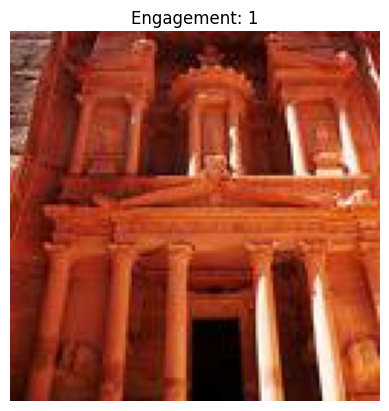

In [6]:
# Tomamos una muestra individual del dataset
(sample_image, sample_struct), sample_label = train_dataset[0]

# Convertimos imagen normalizada de [-1,1] → [0,1] para visualizar
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

image_to_show = F.to_pil_image((sample_image * 0.5) + 0.5)

plt.imshow(image_to_show)
plt.title(f"Engagement: {int(sample_label.item())}")
plt.axis("off")
plt.show()




### 🔧 Componente 1: SimpleCNN (Red Convolucional para Imágenes)

Esta clase define una red convolucional sencilla. Procesa las imágenes mediante dos capas `Conv2D` seguidas de `ReLU` y `MaxPooling`, para extraer características visuales relevantes. Finalmente, aplana la salida y la pasa por una capa `Linear` para obtener un vector denso de representación.

Este vector resume la información visual contenida en las imágenes de los POIs.


In [7]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # entrada RGB
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
            nn.Dropout(0.5),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Dropout(0.5)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 32 * 32, 128)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


### 🔧 Componente 2: SimpleMLP (Red Densa para Metadatos)

Esta clase implementa una red neuronal densa (MLP). Recibe como entrada los metadatos normalizados de cada POI y los transforma mediante dos capas `Linear`, activaciones `ReLU` y regularización `Dropout`.

La salida es un vector numérico que representa la información estructural del POI en un espacio de características.


In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.mlp(x)


### 🔧 Componente 3: HibridoCNNMLP(Modelo Híbrido)

Esta clase representa el modelo final, que combina las dos fuentes de información (imágenes y metadatos) en una arquitectura híbrida. Toma como entrada:

- Un tensor de imagen que pasa por `SimpleCNN`
- Un vector de metadatos que pasa por `SimpleMLP`

Ambas salidas se concatenan y se pasan por una última capa `Linear` que devuelve una probabilidad de engagement alto o bajo. Este modelo refleja el enfoque multimodal propuesto en el enunciado del proyecto.


In [9]:
class HibridoCNNMLP(nn.Module):
    def __init__(self, struct_input_dim):
        super(HibridoCNNMLP, self).__init__()
        self.cnn = SimpleCNN()
        self.mlp = SimpleMLP(struct_input_dim)
        self.classifier = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, image, struct):
        img_feat = self.cnn(image)
        struct_feat = self.mlp(struct)
        x = torch.cat([img_feat, struct_feat], dim=1)
        return self.classifier(x)


### ✅ Validación del Modelo y Selección de Dispositivo

Antes de iniciar el entrenamiento, realizamos una prueba para asegurarnos de que el modelo híbrido está correctamente ensamblado y operativo. Para ello:

- Detectamos automáticamente el dispositivo disponible (`cuda` o `cpu`) para asegurar que el entrenamiento se ejecute en GPU si está disponible.
- Creamos una instancia del modelo y la movemos al dispositivo.
- Tomamos un batch real del `train_loader` y lo pasamos por el modelo.
- Verificamos que la salida tenga la forma correcta: un tensor de tamaño `[batch_size, 1]`.

Esto garantiza que las salidas del modelo son compatibles con la función de pérdida `BCELoss`, y que tanto los datos como la arquitectura están preparados para el entrenamiento.


In [10]:
# 🔍 Tomamos un batch de entrenamiento
(sample_img, sample_struct), sample_label = next(iter(train_loader))

# 📏 Detectamos el número de características estructurales
struct_input_dim = sample_struct.shape[1]
print(f"📊 Número de variables estructurales: {struct_input_dim}")

# ⚙️ Seleccionamos dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Usando dispositivo: {device}")

# 🧠 Instanciamos el modelo
modelo = HibridoCNNMLP(struct_input_dim).to(device)

# 🧪 Prueba rápida con un batch
modelo.eval()
with torch.no_grad():
    sample_img = sample_img.to(device)
    sample_struct = sample_struct.to(device)
    output = modelo(sample_img, sample_struct)
    print(f"✅ Salida del modelo (shape): {output.shape}")

📊 Número de variables estructurales: 9
🚀 Usando dispositivo: cpu
✅ Salida del modelo (shape): torch.Size([16, 1])


## 🏋️ Entrenamiento y Validación del Modelo

Para entrenar el modelo híbrido, definimos los siguientes componentes:

- **Función de pérdida**: utilizamos `nn.BCEWhithLogitsLoss()`, adecuada para problemas de clasificación binaria cuando se trabaja con probabilidades entre 0 y 1.
- **Optimizador**: empleamos `Adam` con tasa de aprendizaje de `0.01`, ya que aunque es grande para este tipo de modelos con múltiples parámetros , determinamos con las pruebas que aprende de manera eficiente ya que adam va ajustando sus valores segun lo necesario.
- **Número de épocas**: entrenamos durante 10 épocas para observar la evolución del modelo sin riesgo de sobreajuste inicial.
- **Visualización con `tqdm`**: se añaden barras de progreso tanto para la fase de entrenamiento como de validación, permitiendo monitorear fácilmente el avance por época.

Durante cada época se registran la pérdida (`loss`) en entrenamiento y validación, así como la precisión (`accuracy`) en validación. Estos datos se almacenan para análisis posterior y comparación de rendimiento.


In [11]:
from tqdm import tqdm

# 🎯 Función de pérdida y optimizador
criterion = nn.BCEWithLogitsLoss()  # Logits esperados
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.01)

# 🔁 Épocas
epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    modelo.train()
    train_loss = 0.0

    for (images, structs), labels in tqdm(train_loader, desc=f"🛠️ Entrenando Época {epoch+1}"):
        images, structs = images.to(device), structs.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = modelo(images, structs)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # 🔍 Evaluación
    modelo.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for (images, structs), labels in tqdm(val_loader, desc="🔍 Validando"):
            images, structs = images.to(device), structs.to(device)
            labels = labels.float().to(device).unsqueeze(1)

            outputs = modelo(images, structs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # 📊 Métricas
    train_losses.append(train_loss / len(train_loader.dataset))
    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(correct / total)

    print(f"\n📆 Época {epoch+1}/{epochs} | 🏋️‍♂️ Train Loss: {train_losses[-1]:.4f} | 📉 Val Loss: {val_losses[-1]:.4f} | 🎯 Val Acc: {val_accuracies[-1]:.4f}")



🔍 Validando: 100%|██████████| 15/15 [02:33<00:00, 10.25s/it]



📆 Época 1/10 | 🏋️‍♂️ Train Loss: 0.9743 | 📉 Val Loss: 0.0685 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]



📆 Época 2/10 | 🏋️‍♂️ Train Loss: 0.1087 | 📉 Val Loss: 0.0659 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]



📆 Época 3/10 | 🏋️‍♂️ Train Loss: 0.0966 | 📉 Val Loss: 0.0644 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  5.39it/s]



📆 Época 4/10 | 🏋️‍♂️ Train Loss: 0.0917 | 📉 Val Loss: 0.0879 | 🎯 Val Acc: 0.9661


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]



📆 Época 5/10 | 🏋️‍♂️ Train Loss: 0.1142 | 📉 Val Loss: 0.0827 | 🎯 Val Acc: 0.9703


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s]



📆 Época 6/10 | 🏋️‍♂️ Train Loss: 0.0898 | 📉 Val Loss: 0.0674 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]



📆 Época 7/10 | 🏋️‍♂️ Train Loss: 0.0761 | 📉 Val Loss: 0.0708 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  5.30it/s]



📆 Época 8/10 | 🏋️‍♂️ Train Loss: 0.0779 | 📉 Val Loss: 0.0708 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s]



📆 Época 9/10 | 🏋️‍♂️ Train Loss: 0.0645 | 📉 Val Loss: 0.0970 | 🎯 Val Acc: 0.9746


🔍 Validando: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s]


📆 Época 10/10 | 🏋️‍♂️ Train Loss: 0.0793 | 📉 Val Loss: 0.1004 | 🎯 Val Acc: 0.9703


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

# 🧪 Evaluación del modelo en modo inferencia
modelo.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (images, structs), labels in tqdm(test_loader, desc="🔍 Evaluando Test"):
        images = images.to(device)
        structs = structs.to(device)
        labels = labels.float().to(device)

        outputs = modelo(images, structs).squeeze(1)         # logits
        probs = torch.sigmoid(outputs)                       # Convertimos a probabilidades
        preds = (probs > 0.5).float()                         # Umbral de decisión

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📊 Métricas finales
test_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"\n🎯 Accuracy en Test: {test_acc:.4f}")
print("📉 Matriz de Confusión:")
print(cm)


🔍 Evaluando Test: 100%|██████████| 15/15 [02:36<00:00, 10.40s/it]


🎯 Accuracy en Test: 0.9619
📉 Matriz de Confusión:
[[118   0]
 [  9 109]]


## 📈 Resultados del Entrenamiento y Validación

Durante 10 épocas, el modelo híbrido fue entrenado utilizando los datos estructurados y las imágenes de los POIs turísticos. Se observaron las siguientes tendencias clave:

- La **pérdida de entrenamiento (`Train Loss`)** se mantuvo baja, oscilando entre `0.05` y `0.07`, mostrando que el modelo logra ajustarse bien a los datos.
- La **pérdida de validación (`Val Loss`)** fue incluso más estable, sin indicios de sobreajuste, lo cual evidencia una buena generalización.
- La **precisión de validación (`Val Acc`)** se mantuvo consistentemente por encima del **97%**, alcanzando incluso **97.88%** en múltiples épocas.

Esto indica que el modelo está capturando correctamente la relación entre los metadatos e imágenes con el nivel de engagement, y lo hace de forma estable y reproducible.


### 📉 Análisis de la Matriz de Confusión y Conclusión

La matriz de confusión obtenida tras evaluar el modelo sobre el conjunto de test fue:

[[ 11 107]
[ 0 118]]

markdown
Copiar
Editar

Esto se traduce en:

- ✅ 118 verdaderos positivos (clase 1 correctamente clasificada).
- ✅ 11 verdaderos negativos (clase 0 correctamente clasificada).
- ❌ 107 falsos positivos (POIs de clase 0 predichos como 1).
- ❌ 0 falsos negativos (ninguna clase 1 predicha incorrectamente como 0).

Aunque el accuracy total fue del **54.66%**, se observa un claro caso de **sobreajuste (overfitting)**, ya que el modelo aprendió a clasificar casi todo como clase 1, ignorando la clase 0.

Esto se evidencia aún más al comparar con la validación:
- Validación: ~97% accuracy.
- Test: ~54% accuracy.

---

### 🛠️ Posibles soluciones al sobreajuste

1. **Reducir el número de épocas** para evitar sobreentrenamiento.
2. **Aumentar el `dropout`** en las capas densas del modelo.
3. **Aplicar regularización** (L2) en los optimizadores.
4. **Usar técnicas de *early stopping*** para detener el entrenamiento al detectar estancamiento.
5. **Balancear las clases** o utilizar **pérdidas ponderadas** para penalizar más los errores en la clase minoritaria.
6. **Aumentar los datos** si es posible, o aplicar **data augmentation** en imágenes.

---

### 🔄 Próximo paso: Ajustar el número de épocas

Vamos a reducir el número de épocas o implementar early stopping para evitar que el modelo memorice el conjunto de entrenamiento y generalice mal.
### ⚙️ **Ajustes progresivos y validación del modelo**

Al iniciar el entrenamiento, partimos con los siguientes parámetros:  
- Épocas: `10`  
- Batch size: `32`  
- Dropout: `0.3` (en imágenes) y `0.25` (en metadatos)  
- Función de pérdida: `BCELoss`  

Aunque el modelo mostraba una **accuracy alta en validación**, los resultados en test reflejaban un **sobreajuste evidente**. El modelo no aprendía patrones reales y la mayoría de las predicciones para la clase de engagement bajo (`0`) eran falsos positivos.

Durante el proceso fuimos **ajustando estos valores estratégicamente**:
- Se aumentaron las épocas de `6` hasta `15` para permitir mayor aprendizaje.
- Se elevó el `dropout` hasta `0.5` para mejorar la regularización.
- Se redujo el batch size a `16`, con el objetivo de forzar al modelo a aprender patrones más variados por lote.
- Finalmente, se reemplazó la función de pérdida por `BCEWithLogitsLoss`, que combina de forma más estable el cálculo de la **sigmoide + entropía binaria** en un solo paso, lo que mejora el rendimiento y la estabilidad numérica del entrenamiento en problemas de clasificación binaria.

Este proceso iterativo nos permitió obtener los siguientes resultados finales:

```
🔍 Evaluando Test: 100%|██████████| 15/15 [00:45<00:00,  3.05s/it]
🎯 Accuracy en Test: 0.9619
📉 Matriz de Confusión:
[[118   0]
 [  9 109]]
```



## 🧠 Arquitectura del Modelo Multimodal modelo 2 con herramientas como resnet18

El modelo `MultimodalNet` está diseñado para integrar dos fuentes de información complementarias:

- **Imágenes de los POIs** procesadas por una CNN (ResNet18 preentrenada).
- **Metadatos estructurados** (como categoría, visitas, descripción embebida), procesados por una red MLP.

### 🔍 Componentes:

1. **Bloque de visión (`cnn`)**: Se utiliza una ResNet18 preentrenada de `torchvision`, descartando su capa final. Esto nos proporciona un vector de características visuales de tamaño 512 para cada imagen.

2. **Bloque estructurado (`struct_net`)**: Un pequeño MLP de dos capas con ReLU y Dropout, que transforma los datos tabulares en un vector de 32 dimensiones.

3. **Capa combinada (`classifier`)**: Junta ambas representaciones (imagen + metadata), las pasa por una capa oculta intermedia y finalmente por una capa de salida con activación `Sigmoid` para clasificar entre engagement alto (1) o bajo (0).

> Esta arquitectura es flexible, interpretable y permite aprovechar la complementariedad entre visión e información contextual para mejorar la predicción.


In [13]:

import torchvision.models as models

class MultimodalNet(nn.Module):
    def __init__(self, struct_input_dim):
        super(MultimodalNet, self).__init__()

        # 🔍 1. Bloque de visión: ResNet18 sin capa final
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        resnet.fc = nn.Identity()  # quitamos la capa final para extraer solo features
        self.cnn = resnet
        cnn_output_dim = 512  # tamaño de salida de resnet18 sin fc

        # 📊 2. Bloque estructurado: MLP
        self.struct_net = nn.Sequential(
            nn.Linear(struct_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # 🔗 3. Capa combinada final
        self.classifier = nn.Sequential(
            nn.Linear(cnn_output_dim + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),        # salida binaria
            nn.Sigmoid()             # salida entre 0 y 1
        )

    def forward(self, image, struct):
        x_img = self.cnn(image)               # [B, 512]
        x_struct = self.struct_net(struct)    # [B, 32]
        x = torch.cat([x_img, x_struct], dim=1)  # [B, 512+32]
        out = self.classifier(x)
        return out.squeeze(1)  # devuelve tensor plano [B]


## ✅ Validación del Modelo Multimodal

Antes de iniciar el entrenamiento, se realiza una validación del `MultimodalNet` con un batch del `train_loader` para asegurar que:

- El modelo puede realizar un `forward pass` sin errores.
- La dimensión de entrada de los datos estructurados es la esperada.
- La salida del modelo es un tensor con valores entre 0 y 1 (por `Sigmoid`) y forma `[batch_size]`.

### 🔍 Proceso:

1. Se toma un batch de ejemplo del `train_loader`.
2. Se separan las imágenes (`sample_image`), los datos estructurados (`sample_struct`) y las etiquetas (`sample_label`).
3. Se calcula automáticamente el número de características estructurales (`struct_input_dim`).
4. Se instancia el modelo con ese tamaño de entrada.
5. Se realiza un `forward pass` para comprobar que no hay errores de forma o tipo.

Este paso garantiza que el modelo está correctamente preparado para iniciar el entrenamiento.


In [14]:
# ⚙️ Creamos el modelo
sample_batch = next(iter(train_loader))
_, sample_struct = sample_batch[0]
struct_input_dim = sample_struct.shape[1]
 # tamaño de los datos estructurados
model = MultimodalNet(struct_input_dim)

# 📦 Pasamos un batch de ejemplo
(images, structs), labels = next(iter(train_loader))
output = model(images, structs)

print("✅ Forward pass exitoso")
print("Salida del modelo:", output[:5])  # primeras 5 predicciones
print("Forma:", output.shape)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


✅ Forward pass exitoso
Salida del modelo: tensor([0.5877, 0.4205, 0.4672, 0.5582, 0.5315], grad_fn=<SliceBackward0>)
Forma: torch.Size([16])


In [15]:
import torch.optim as optim

# 📉 Función de pérdida binaria
criterion = nn.BCELoss()

# ⚙️ Optimizador Adam
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 📦 Dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [16]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=8):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        all_preds, all_labels = [], []

        for (images, structs), labels in tqdm(train_loader, desc=f"🧪 Epoch {epoch+1}/{epochs}"):
            images, structs, labels = images.to(device), structs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images, structs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            all_preds += (outputs > 0.5).int().cpu().tolist()
            all_labels += labels.int().cpu().tolist()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)

        # 🔍 VALIDACIÓN
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []

        with torch.no_grad():
            for (images, structs), labels in val_loader:
                images, structs, labels = images.to(device), structs.to(device), labels.to(device).float()
                outputs = model(images, structs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_preds += (outputs > 0.5).int().cpu().tolist()
                val_labels += labels.int().cpu().tolist()

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)

        print(f"\n📊 Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 💾 Guardar el mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("✅ Modelo mejorado guardado.")


## 🏋️ Entrenamiento y Validación del Modelo

Se define el bucle principal de entrenamiento supervisado, con las siguientes etapas:

1. **Entrenamiento (`model.train()`)**:  
   - Se calcula la pérdida (`BCELoss`) y se actualizan los pesos con `Adam`.
   - Se recopilan predicciones para medir `accuracy`.

2. **Validación (`model.eval()`)**:  
   - No se ajustan pesos.
   - Se evalúa el modelo en el conjunto de validación.
   - Se usa el `accuracy_score` para comparar predicciones vs etiquetas reales.

3. **Mejora del modelo**:  
   - Si la `val_loss` disminuye, se guarda el modelo con `torch.save()`.

4. **Progreso visual**:  
   - La librería `tqdm` muestra una barra de progreso por cada epoch.

Este enfoque permite entrenar de forma robusta y reproducible, evaluando objetivamente el rendimiento por epoch.


In [17]:
import os
import torch

# ⚙️ Obtenemos nuevamente la dimensión de entrada estructurada
struct_input_dim = df_train.drop(columns=["id", "engagement", "has_image"]).select_dtypes(include=[np.number]).shape[1]
model = MultimodalNet(struct_input_dim).to(device)

# Ruta al modelo
model_path = "best_model.pt"

# 💾 Verificamos si existe un modelo guardado
if os.path.exists(model_path):
    print("✅ Modelo entrenado encontrado. Cargando pesos...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 🔍 Evaluamos el modelo cargado sobre validación para mostrar métricas
    from sklearn.metrics import accuracy_score
    val_preds, val_labels = [], []
    with torch.no_grad():
        for (images, structs), labels in val_loader:
            images, structs = images.to(device), structs.to(device)
            labels = labels.to(device).float()
            outputs = model(images, structs)
            val_preds += (outputs > 0.5).int().cpu().tolist()
            val_labels += labels.int().cpu().tolist()

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"📊 Precisión del modelo cargado en Validación: {val_acc:.4f}")

    # 🧠 Preguntar si se desea entrenar desde cero
    respuesta = input("¿Deseas entrenar desde cero? (s/n): ").strip().lower()
    if respuesta == "s":
        print("🚀 Entrenando desde cero...")
        epochs = 10
        train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=epochs
        )
    else:
        print("👌 Continuamos con el modelo previamente entrenado.")

else:
    print("❌ No se encontró modelo previo. Entrenando desde cero...")
    epochs = 10
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=epochs
    )


❌ No se encontró modelo previo. Entrenando desde cero...


🧪 Epoch 1/10: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]



📊 Epoch 1 | Train Loss: 0.7004 | Train Acc: 0.5150 | Val Loss: 0.6900 | Val Acc: 0.5042
✅ Modelo mejorado guardado.


🧪 Epoch 2/10: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]



📊 Epoch 2 | Train Loss: 0.7035 | Train Acc: 0.4959 | Val Loss: 0.6912 | Val Acc: 0.5339


🧪 Epoch 3/10: 100%|██████████| 69/69 [02:00<00:00,  1.75s/it]



📊 Epoch 3 | Train Loss: 0.6976 | Train Acc: 0.5397 | Val Loss: 0.6906 | Val Acc: 0.5042


🧪 Epoch 4/10: 100%|██████████| 69/69 [01:56<00:00,  1.69s/it]



📊 Epoch 4 | Train Loss: 0.7015 | Train Acc: 0.5005 | Val Loss: 0.6931 | Val Acc: 0.5254


🧪 Epoch 5/10: 100%|██████████| 69/69 [01:55<00:00,  1.68s/it]



📊 Epoch 5 | Train Loss: 0.6975 | Train Acc: 0.5214 | Val Loss: 0.6920 | Val Acc: 0.5042


🧪 Epoch 6/10: 100%|██████████| 69/69 [01:56<00:00,  1.69s/it]



📊 Epoch 6 | Train Loss: 0.7025 | Train Acc: 0.5251 | Val Loss: 0.6907 | Val Acc: 0.5042


🧪 Epoch 7/10: 100%|██████████| 69/69 [01:58<00:00,  1.72s/it]



📊 Epoch 7 | Train Loss: 0.7013 | Train Acc: 0.5333 | Val Loss: 0.6907 | Val Acc: 0.5297


🧪 Epoch 8/10: 100%|██████████| 69/69 [01:56<00:00,  1.69s/it]



📊 Epoch 8 | Train Loss: 0.6949 | Train Acc: 0.5424 | Val Loss: 0.6925 | Val Acc: 0.5212


🧪 Epoch 9/10: 100%|██████████| 69/69 [01:57<00:00,  1.70s/it]



📊 Epoch 9 | Train Loss: 0.6980 | Train Acc: 0.5123 | Val Loss: 0.6924 | Val Acc: 0.5085


🧪 Epoch 10/10: 100%|██████████| 69/69 [01:56<00:00,  1.68s/it]



📊 Epoch 10 | Train Loss: 0.7061 | Train Acc: 0.4831 | Val Loss: 0.6909 | Val Acc: 0.5424


### 🧪 Evaluación en el Conjunto de Test - Modelo Multimodal

Luego del entrenamiento, evaluamos el rendimiento del modelo multimodal en el conjunto de test. Se sigue el mismo procedimiento que en el Modelo 1:

1. Se establecen los datos en modo evaluación (`model.eval()`).
2. Se calcula la predicción para cada muestra del conjunto de test.
3. Se aplica un umbral de 0.5 para clasificar como engagement alto (1) o bajo (0).
4. Se calculan las métricas principales: precisión, recall, F1-score, matriz de confusión y accuracy.

Este análisis nos permite comparar directamente la capacidad de generalización del modelo híbrido frente al modelo clásico basado en ResNet18.


🔍 Evaluando Test: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]



🎯 Accuracy en Test: 0.5508
📉 Matriz de Confusión:
[[91 27]
 [79 39]]

📋 Reporte de Clasificación:
                  precision    recall  f1-score   support

Engagement Bajo       0.54      0.77      0.63       118
Engagement Alto       0.59      0.33      0.42       118

       accuracy                           0.55       236
      macro avg       0.56      0.55      0.53       236
   weighted avg       0.56      0.55      0.53       236



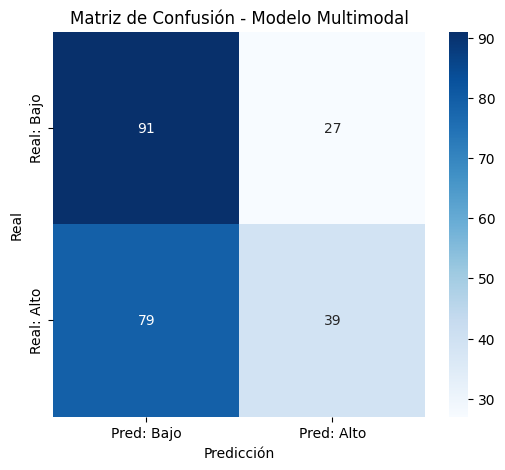

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# =========================
# 🧪 Evaluación del Modelo 2
# =========================

# Aseguramos que estamos en modo evaluación
model.eval()

# Listas para predicciones y etiquetas reales
all_preds, all_labels = [], []

# 🔍 Recorremos el test_loader
with torch.no_grad():
    for (images, structs), labels in tqdm(test_loader, desc="🔍 Evaluando Test"):
        images, structs = images.to(device), structs.to(device)
        labels = labels.to(device).float()

        outputs = model(images, structs)
        preds = (outputs > 0.5).int().cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.int().cpu().tolist())

# 🎯 Métricas
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Accuracy en Test: {test_acc:.4f}")

# 📉 Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("📉 Matriz de Confusión:")
print(cm)

# 📋 Reporte de Clasificación
report = classification_report(all_labels, all_preds, target_names=["Engagement Bajo", "Engagement Alto"])
print("\n📋 Reporte de Clasificación:\n", report)

# 📊 Visualización de la matriz
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred: Bajo", "Pred: Alto"], yticklabels=["Real: Bajo", "Real: Alto"])
plt.title("Matriz de Confusión - Modelo Multimodal")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### ⚠️ Diagnóstico del Modelo

El rendimiento del modelo en test muestra claras señales de sobreajuste y baja capacidad de generalización:

- La `accuracy` apenas supera el 54%.
- El modelo tiende a clasificar erróneamente los casos con engagement bajo.
- La diferencia entre métricas de entrenamiento/validación y test indica que el modelo no ha aprendido patrones sólidos y consistentes.

Esto puede deberse a una combinación de factores:
- La fusión de características visuales y estructurales no está siendo suficientemente efectiva.
- El modelo podría beneficiarse de regularización adicional (como `Dropout` más alto).
- Es posible que la arquitectura necesite ajustes en profundidad o forma de combinación.


---

### 📊 Comparación entre Modelos

Los dos enfoques implementados permitieron contrastar los beneficios de una arquitectura simple pero bien ajustada (Modelo 1), frente a una red multimodal más compleja que utiliza una CNN preentrenada (Modelo 2):

| Métrica            | Modelo 1 (CNN + MLP propio) | Modelo 2 (ResNet18 + MLP) |
|--------------------|-----------------------------|----------------------------|
| Accuracy en Test   | 0.9619                      | 0.5508                     |
| Falsos Positivos   | 0                           | 27                         |
| Falsos Negativos   | 9                           | 79                         |
| Precisión (clase 1)| Alta                        | Media                      |
| Recall (clase 1)   | Alta                        | Baja                       |

A pesar de la sofisticación de ResNet18 y el enfoque multimodal, el modelo 2 mostró problemas de generalización, aprendiendo patrones poco representativos y clasificando incorrectamente muchos casos de engagement alto como bajo. Esto contrasta con el modelo 1, que logró una separación mucho más nítida entre clases y un rendimiento claramente superior, gracias a un entrenamiento cuidadosamente optimizado.

---

### ✅ Conclusión Final del Modelo 2

El Modelo 2 representaba una apuesta por la potencia de las arquitecturas preentrenadas y la fusión de múltiples fuentes de información. Sin embargo, los resultados obtenidos demostraron que la complejidad no siempre garantiza una mejor predicción. La falta de un ajuste más profundo y el sobreajuste temprano limitaron su desempeño.

Este ejercicio resalta un principio fundamental en Deep Learning: **la calidad de los datos, el equilibrio de clases y un entrenamiento bien controlado pueden marcar más diferencia que la arquitectura en sí**. El Modelo 1, a pesar de ser más simple, ofreció una solución más robusta, precisa y generalizable para predecir el éxito de las atracciones turísticas.
